In [110]:
!pip install lightgbm xgboost -q

In [111]:
import pandas as pd
import matplotlib.pyplot as plt 

dataset = pd.read_csv('./sample-ALL-NEO-egtm.csv', parse_dates=['reportts']) \
  .sort_values('reportts')

In [112]:
dataset

,acnum,reportts,pos,fltdes,dep,arr,ivs12,ibe,iaie,iai,...,wai,nai,prv,hpv,xf,reason,recordedts,egtm,n1_delt,n2_delt
0,VQ-BDQ,2018-05-27 23:49:44,1,3510.0,UHHH,UNNT,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,NaN,2018-05-27 23:01:23,128.704,NaN,NaN
163,VQ-BDQ,2018-05-27 23:49:44,2,3510.0,UHHH,UNNT,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,NaN,2018-05-27 23:01:23,134.397,NaN,NaN
1,VQ-BDQ,2018-05-29 09:04:17,1,3315.0,UNNT,URSS,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,NaN,2018-05-29 08:05:07,128.171,NaN,NaN
164,VQ-BDQ,2018-05-29 09:04:17,2,3315.0,UNNT,URSS,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,NaN,2018-05-29 08:05:07,135.588,NaN,NaN
2,VQ-BDQ,2018-06-07 16:32:25,1,3337.0,UNNT,ULLI,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,NaN,2018-06-07 16:02:00,123.514,-0.110001,-0.257705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,VQ-BDQ,2020-12-01 00:34:45,2,5258.0,UHSS,UNNT,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,NaN,2020-12-01 00:02:00,105.752,-0.070000,-0.126868
162,VQ-BDQ,2020-12-01 05:07:30,1,0.0,UHSS,UNNT,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,STW 36 BIT 20,2020-12-01 05:05:00,106.936,-0.059998,-0.119641
325,VQ-BDQ,2020-12-01 05:07:30,2,0.0,UHSS,UNNT,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,0.0,STW 36 BIT 20,2020-12-01 05:05:00,105.629,-0.049995,-0.154879
1059,VQ-BGU,NaT,1,NaN,XXXX,XXXX,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,FUEL FLOW ANOMALY,2020-11-02 02:09:00,17.039,-0.089996,-0.493596


In [113]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [114]:
Y = dataset[['egtm', 'n1_delt', 'n2_delt']]

X = dataset.drop(columns=[
    'reportts', 'acnum', 'pos', 'dep', 'arr', 
    'egtm', 'n1_delt', 'n2_delt', 'fltdes',
    'dmusw', 'exswpn', 'reason', 'recordedts'
]).fillna(-100)

X = X.loc[:, ~X.columns.str.contains('stw')]

In [115]:
def get_score_by_parameter(predict_field, alg='catboost'):
  y = Y[predict_field]

  x = X[y.notna()]

  y = y.dropna()
  
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
  
  # assert len(x) == len(y)
  # train_i = int(len(x) * 60 / 100)
  # X_train, y_train = x[0:train_i], y[0:train_i]
  # X_test, y_test = x[train_i:], y[train_i:]

  model = None
  if alg == 'catboost':
    model = CatBoostRegressor(iterations=200, random_state=42, verbose=False)
  elif alg == 'lightgbm':
    model = LGBMRegressor(random_state=42)
  elif alg == 'xgboost':
    model = XGBRegressor()
  elif alg == 'rand_forest':
    model = RandomForestRegressor(n_estimators=100, random_state=42)
  
  model.fit(X_train, y_train)
  predicted = model.predict(X_test)
  mse = mean_squared_error(y_test, predicted, squared=False)
  mae = mean_absolute_error(y_test, predicted)
  
  return mse, mae, model

In [116]:
scores = pd.DataFrame(columns=["model", "parameter", "rmse", "mae"])
model_types = ["rand_forest", "lightgbm", "catboost", "xgboost"]

models = {}
output_parameters = Y.columns

for model in model_types:
  for param in output_parameters:
    mse, mae, result_model = get_score_by_parameter(param, model)
    models[model + "_" + param] = result_model
    scores.loc[len(scores)] = [model, param, mse, mae]

scores

,model,parameter,rmse,mae
0,rand_forest,egtm,7.664429,3.690654
1,rand_forest,n1_delt,0.029100,0.019476
2,rand_forest,n2_delt,0.099542,0.067643
3,lightgbm,egtm,7.878747,3.761622
4,lightgbm,n1_delt,0.028663,0.019648
5,lightgbm,n2_delt,0.101939,0.068035
6,catboost,egtm,6.473081,4.167992
7,catboost,n1_delt,0.029120,0.019621
8,catboost,n2_delt,0.088413,0.061960
9,xgboost,egtm,8.619192,3.171551


[Text(0, 0, '7.66443'),
 Text(0, 0, '7.87875'),
 Text(0, 0, '6.47308'),
 Text(0, 0, '8.61919')]

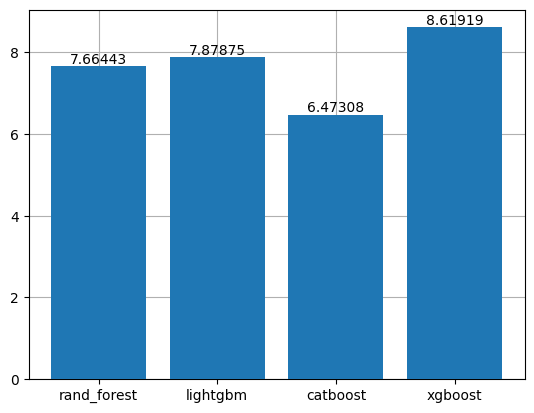

In [117]:
fig, ax = plt.subplots(1, 1)
ax.grid(zorder=0)
ax.bar(model_types, scores[scores['parameter'] == 'egtm']['rmse'], align='center', zorder=3)
ax.bar_label(ax.containers[0], label_type='edge')

In [120]:


catboost = models['lightgbm_egtm'].predict(X[600:1700])
light = models['catboost_egtm'].predict(X[600:1700])

pd.DataFrame({'egtm': Y['egtm'][600:1700], 'light': light, 'catboost': catboost})


,egtm,light,catboost
1330,22.385,23.954272,23.329852
596,21.590,25.167486,21.846429
597,21.590,25.891843,22.131798
1331,22.385,24.210087,22.787872
1332,22.385,24.191580,22.458465
...,...,...,...
1761,20.720,19.608297,18.904282
1028,20.462,19.173159,21.383723
1762,20.720,18.860510,20.476593
1763,20.720,19.695191,19.688968


1. Добавить линейную регрессию 
1. Разделить расчёт метрик по двигателям и фазам полёта
1. A321 - меньше допустимый запас egtm
1. В идеале EGTM +/- 2 градуса
1. Разделение по фазе полёта 
1. Построить корелляции каждого признака с таргетом
1. В дальнейшем использовать это для feature selection